[Load Data](#load)

[Data Preparation](#prepare)
1. [Balance and Split](#bs)
2. [Scale](#scale)

[Model](#model)
1. [Random Forest](#rf)
2. [Gaussian NB](#gnb)
3. [Logistic Regression](#logit)
4. [KNN](#knn)
5. [Neural Network](#nn)

[Evaluation](#evaluation)
1. [Precision & Recall](#precision_recall)
2. [AUC ROC](#auc_roc)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm_notebook as tqdm

<a id='load'></a>
# Load data

In [11]:
data = pd.read_csv('./data.csv')

<a id='prepare'></a>
# Prepare data

In [13]:
exclude = ['horse_num','oriental_sum','apple_sum','pro_sum',
           'total_1','total_2','total_3','total_sum','file_name',
           'sheet_name','W.H. FixOdd 60','S.B.Fix Odd 60']

In [14]:
data_ex = data[[i for i in list(data) if i not in exclude]].dropna()
X = data_ex[[i for i in data_ex if i != 'result']]
y = (data_ex['result'] > 0).astype('int')

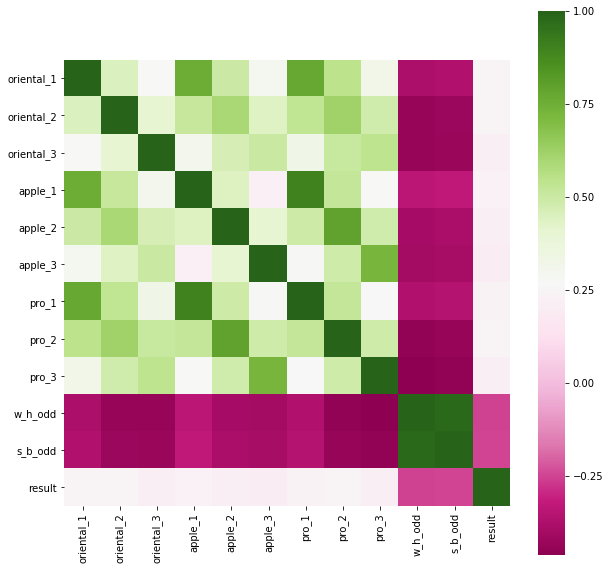

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(data_ex.corr(), square=True, cmap='PiYG')
plt.show()

<a id='bs'></a>
## Balance and Split

In [16]:
from imblearn import over_sampling, under_sampling
from imblearn.pipeline import Pipeline

Using TensorFlow backend.


In [17]:
# create sampling strategy
# both oversampling and undersampling
over = over_sampling.SMOTE(0.8)
under = under_sampling.RandomUnderSampler(0.8)

In [18]:
# create pipeline
pipeline = Pipeline([('o', over),('u', under)])

In [19]:
X_sam, y_sam = pipeline.fit_resample(X, y)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_sam, y_sam, test_size=0.15)

<a id='scale'></a>
## Scale

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)

<a id='model'></a>
# Model

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
def precision_recall(true, predict, print_=True):
    cm = confusion_matrix(true, predict)
    if print_:
        print('Confusion Matrix:')
        print(cm)
        print()
    
    tn, fp, fn, tp = confusion_matrix(true, predict).ravel()
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    
    if print_:
        print('Precision:', precision)
        print('Recall:', recall)
    else:
        return precision, recall

<a id='rf'></a>
## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [33]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2,
                               random_state=42, 
                               n_jobs = -1)

In [35]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [36]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [37]:
rf_best = RandomForestClassifier(n_estimators=800, 
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 max_features='sqrt',
                                 max_depth=50,
                                 bootstrap=False)

In [38]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
import pickle

In [41]:
# filename = 'model_rf.sav'
# pickle.dump(rf_best, open(filename, 'wb'))

<a id='svm'></a>
## SVM

In [42]:
from sklearn.svm import SVC

In [43]:
svm = SVC(gamma='auto',)
svm.fit(X_train_n, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

<a id='gnb'></a>
## Gaussian NB

In [44]:
from sklearn.naive_bayes import GaussianNB

In [45]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

<a id='logit'></a>
## Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegressionCV

In [47]:
logit = LogisticRegressionCV(cv=10, verbose=2)
logit.fit(X_train_n, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=2)

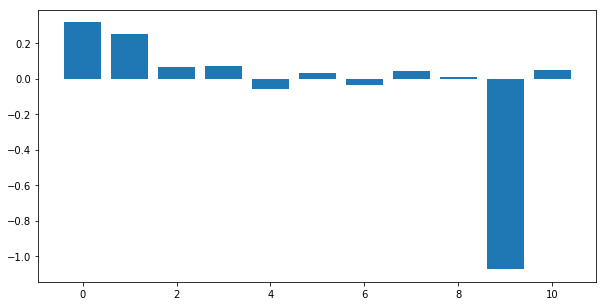

In [48]:
plt.figure(figsize=(10,5))
plt.bar(range(len(logit.coef_.reshape(-1))), logit.coef_.reshape(-1))
plt.show()

<a id='knn'></a>
## KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [50]:
def knn_cv(n, X, y):
    knn = KNeighborsClassifier(n_neighbors=n)
    score = cross_val_score(knn, X, y, cv=10)
    return score.mean()

In [51]:
all_knn_scores = [knn_cv(i, X_train_n, y_train) for i in tqdm(range(3, 99, 2))]

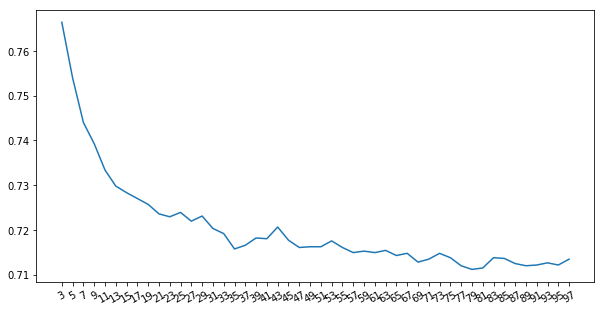

In [52]:
plt.figure(figsize=(10,5))
plt.plot(all_knn_scores)
plt.xticks(range(len(all_knn_scores)), range(3,99,2), rotation=30)
plt.show()

In [53]:
knn_best = KNeighborsClassifier(n_neighbors=3)
knn_best.fit(X_train_n, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

<a id='nn'></a>
## Neural Network

In [54]:
X_val_n, X_test_dnn, y_val, y_test_dnn = train_test_split(X_test_n, y_test, test_size=0.2)

In [55]:
from keras import models
from keras import layers

In [56]:
dnn = models.Sequential()
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(1, activation='sigmoid'))

W0425 05:29:02.220214 4733945280 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0425 05:29:02.236037 4733945280 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0425 05:29:02.239881 4733945280 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0425 05:29:02.254296 4733945280 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0425 05:29:02.261064 4733945280 deprecati

In [57]:
dnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

W0425 05:29:04.241611 4733945280 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0425 05:29:04.262548 4733945280 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0425 05:29:04.266794 4733945280 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [58]:
history = dnn.fit(X_train_n, y_train, 
                    epochs=100, 
                    batch_size=512, 
                    verbose=0,
                    validation_data=[X_val_n, y_val])

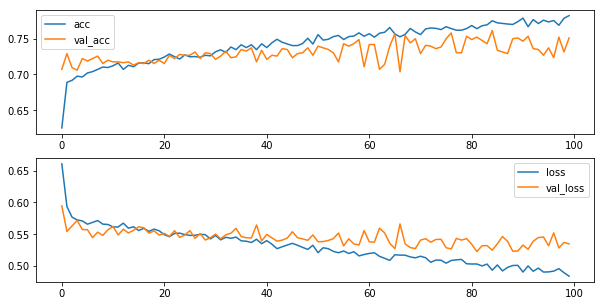

In [59]:
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()

In [60]:
dnn_best = models.Sequential()
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(1, activation='sigmoid'))

In [61]:
dnn_best.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [62]:
history_best = dnn_best.fit(X_train_n, y_train, 
                            epochs=40, 
                            batch_size=512, 
                            verbose=0,
                            validation_data=[X_val_n, y_val])

<a id='evaluation'></a>
# Evaluation

<a id='precision_recall'></a>
## Precision & Recall

In [63]:
# random forest
rf_score = rf_best.score(X_test, y_test)
rf_predict = rf_best.predict(X_test)

In [64]:
# svm
svm_score = svm.score(X_test_n, y_test)
svm_predict = svm.predict(X_test_n)

In [65]:
# gnb
gnb_score = gnb.score(X_test, y_test)
gnb_predict = gnb.predict(X_test)

In [66]:
# logistic regression
logit_score = logit.score(X_test_n, y_test)
logit_predict = logit.predict(X_test_n)

In [67]:
# knn
knn_score = knn_best.score(X_test_n, y_test)
knn_predict = knn_best.predict(X_test_n)

In [68]:
# nn
dnn_loss, dnn_score = dnn_best.evaluate(X_test_dnn, y_test_dnn)
dnn_predict = pd.Series(dnn_best.predict(X_test_dnn).reshape(-1) >= 0.5).astype('int')

217/217 [==============================] - 0s 50us/step


In [69]:
from sklearn.metrics import roc_curve, auc

In [70]:
dnn_fpr, dnn_tpr, dnn_threshold = roc_curve(y_test_dnn, dnn_best.predict(X_test_dnn).reshape(-1))
dnn_auc = auc(dnn_fpr, dnn_tpr)

In [71]:
pr_dict = {
    'rf':precision_recall(y_test, rf_predict, print_=False),
    'svm':precision_recall(y_test, svm_predict, print_=False),
    'gnb':precision_recall(y_test, gnb_predict, print_=False),
    'logit':precision_recall(y_test, logit_predict, print_=False),
    'knn':precision_recall(y_test, knn_predict, print_=False),
    'dnn':precision_recall(y_test_dnn, dnn_predict, print_=False)
}

In [72]:
pr_df = pd.DataFrame.from_dict(pr_dict, orient='index', columns=['precision','recall'])
pr_df['F1'] = 2*((pr_df['precision']*pr_df['recall']) / (pr_df['precision']+pr_df['recall']))
pr_df['accuracy'] = [rf_score, svm_score, gnb_score, logit_score, knn_score, dnn_score]

In [73]:
pr_df

,precision,recall,F1,accuracy
rf,0.830803,0.796258,0.813163,0.837188
svm,0.695035,0.611227,0.650442,0.707678
gnb,0.677494,0.607069,0.640351,0.696577
logit,0.678815,0.619543,0.647826,0.700278
knn,0.720562,0.852391,0.780952,0.787234
dnn,0.650943,0.711340,0.679803,0.700461


In [74]:
rf_best.predict_proba(X_test)

array([[0.5227339 , 0.4772661 ],
       [0.92891673, 0.07108327],
       [0.77369748, 0.22630252],
       ...,
       [0.14416667, 0.85583333],
       [0.9843663 , 0.0156337 ],
       [0.01583333, 0.98416667]])

<a id='auc_roc'></a>
## AUC ROC

In [75]:
from sklearn.metrics import plot_roc_curve

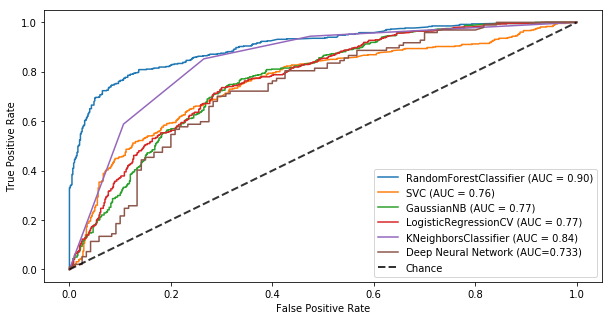

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
plot_roc_curve(rf_best, X_test, y_test, ax=ax)
plot_roc_curve(svm, X_test_n, y_test, ax=ax)
plot_roc_curve(gnb, X_test, y_test, ax=ax)
plot_roc_curve(logit, X_test_n, y_test, ax=ax)
plot_roc_curve(knn_best, X_test_n, y_test, ax=ax)
plt.plot(dnn_fpr, dnn_tpr, label='Deep Neural Network (AUC={})'.format(round(dnn_auc, 3)))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='Chance', alpha=.8)
plt.legend()
plt.show()